# Evaluación de resultados

Técnicas para la evaluación de los resultados de una predicción con algoritmos de Machine Learning

Dataset: https://www.unb.ca/cic/datasets/nsl.html

## Imports

In [1]:
import arff
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

## Funciones auxiliares

In [2]:
def load_kdd_dataset(data_path):
  """Lectura del conjunto de datos"""
  with open(data_path, 'r') as train_set:
    dataset = arff.load(train_set)
  attributes = [attr[0] for attr in dataset['attributes']]

  return pd.DataFrame(dataset['data'], columns=attributes)

In [3]:
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
  strat = df[stratify] if stratify else None
  train_set, test_set = train_test_split(
    df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat
  )
  strat = test_set[stratify] if stratify else None
  val_set, test_set = train_test_split(
    test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat
  )

  return (train_set, val_set, test_set)

In [4]:
# Construcción de un Pipeline para todos los atributos numéricos
num_pipeline = Pipeline([
  ('imputer', SimpleImputer(strategy='median')),
  ('rbst_scaler', RobustScaler())
])

In [17]:
# Transformador para codificar las columnas catregoricas
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._oh = OneHotEncoder(sparse=False)
        self._columns = None
    def fit(self, X, y=None):
        X_cat = X.select_dtypes(include=['object'])
        self._columns = pd.get_dummies(X_cat).columns
        self._oh.fit(X_cat)
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_cat = X_copy.select_dtypes(include=['object'])
        X_num = X_copy.select_dtypes(exclude=['object'])
        X_cat_oh = self._oh.transform(X_cat)
        X_cat_oh = pd.DataFrame(X_cat_oh, 
                                columns=self._columns, 
                                index=X_copy.index)
        X_copy.drop(list(X_cat), axis=1, inplace=True)
        return X_copy.join(X_cat_oh)

In [18]:
# Transformador para preparar todo el conjunto de datos llamado pipelines y transofrmadores personalizados
class DataFramePreparer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._full_pipeline = None
        self._columns = None
    def fit(self, X, y=None):
        num_attribs = list(X.select_dtypes(exclude=['object']))
        cat_attribs = list(X.select_dtypes(include=['object']))
        self._full_pipeline = ColumnTransformer([
                ("num", num_pipeline, num_attribs),
                ("cat", CustomOneHotEncoder(), cat_attribs),
        ])
        self._full_pipeline.fit(X)
        self._columns = pd.get_dummies(X).columns
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_prep = self._full_pipeline.transform(X_copy)
        return pd.DataFrame(X_prep, 
                            columns=self._columns, 
                            index=X_copy.index)

## Lectura del conjunto de datos

In [7]:
df = load_kdd_dataset('../datasets/NSL-KDD/KDDTrain+.arff')

In [8]:
df.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,tcp,ftp_data,SF,491.0,0.0,0,0.0,0.0,0.0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0.0,udp,other,SF,146.0,0.0,0,0.0,0.0,0.0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0.0,tcp,http,SF,232.0,8153.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0.0,tcp,http,SF,199.0,420.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
5,0.0,tcp,private,REJ,0.0,0.0,0,0.0,0.0,0.0,...,19.0,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
6,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,9.0,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
7,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,15.0,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
8,0.0,tcp,remote_job,S0,0.0,0.0,0,0.0,0.0,0.0,...,23.0,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
9,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,13.0,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00,anomaly


## División del conjunto de datos

In [9]:
# Divisiön del conjunto en subconjuntos
train_set, val_set, test_set = train_val_test_split(df)

In [10]:
print('Training set: ', len(train_set))
print('Validation set: ', len(val_set))
print('Test set: ', len(test_set))

Training set:  75583
Validation set:  25195
Test set:  25195


Separación de las etiquetas

In [11]:
# Conjunto general
X_df = df.drop('class', axis=1)
y_df = df['class'].copy()

In [12]:
# Conjunto de entrenamiento
X_train = train_set.drop('class', axis=1)
y_train = train_set['class'].copy()

In [13]:
# Conjunto de validación
X_val = val_set.drop('class', axis=1)
y_val = val_set['class'].copy()

In [14]:
X_test = test_set.drop('class', axis=1)
y_test = test_set['class'].copy()

## Preparación del conjunto de datos 

In [19]:
# Instancia de nuestro transformador personalizado
data_preparer = DataFramePreparer()

In [20]:
# Hacemos fit con el conjunto de datos general para que adquiera todos los valores posibles
data_preparer.fit(X_df)

DataFramePreparer()

In [21]:
# transformamos el suconjunto de datos de entrenamiento
X_train_prep = data_preparer.transform(X_train)

In [22]:
X_train.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
98320,0.0,icmp,ecr_i,SF,1032.0,0.0,0,0.0,0.0,0.0,...,210.0,65.0,0.31,0.01,0.31,0.00,0.0,0.0,0.0,0.0
8590,0.0,tcp,smtp,SF,1762.0,331.0,0,0.0,0.0,0.0,...,30.0,122.0,0.73,0.07,0.03,0.02,0.0,0.0,0.0,0.0
91385,0.0,icmp,eco_i,SF,8.0,0.0,0,0.0,0.0,0.0,...,2.0,126.0,1.00,0.00,1.00,0.25,0.0,0.0,0.0,0.0
54349,0.0,tcp,csnet_ns,S0,0.0,0.0,0,0.0,0.0,0.0,...,255.0,18.0,0.07,0.07,0.00,0.00,1.0,1.0,0.0,0.0
69568,0.0,tcp,smtp,SF,1518.0,342.0,0,0.0,0.0,0.0,...,83.0,125.0,0.66,0.05,0.01,0.02,0.0,0.0,0.0,0.0


In [25]:
X_train_prep.head(5)

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag_SF,flag_SH,land_0,land_1,logged_in_0,logged_in_1,is_host_login_0,is_host_login_1,is_guest_login_0,is_guest_login_1
98320,0.0,3.579710,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
8590,0.0,6.224638,0.641473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
91385,0.0,-0.130435,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
54349,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
69568,0.0,5.340580,0.662791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [26]:
# transformamos el subconjunto de datos de validación
X_val_prep = data_preparer.transform(X_val)

## Entrenamiento de un algoritmo de regresiión logística


La instanciación de un algoritmo de Machine Learning utilizando sklearn se realiza utilizado los métodos expuestos por la API de sklearn

In [27]:
# Entrenamos un algorimo basado en regresión logística
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=5000)
clf.fit(X_train_prep, y_train)

c:\Users\luigi\.conda\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=5000)

## Predicción de nuevos ejemplos

Realizamos una predicción con el modelo generado anteriormente tras el entrenamiento del algoritmo de regresión logística utilizando el subconjunto de validación

In [29]:
y_pred = clf.predict(X_val_prep)

## 1. Matriz de confusión

In [30]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_val, y_pred)

array([[11422,   452],
       [  273, 13048]], dtype=int64)

c:\Users\luigi\.conda\envs\machine_learning\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


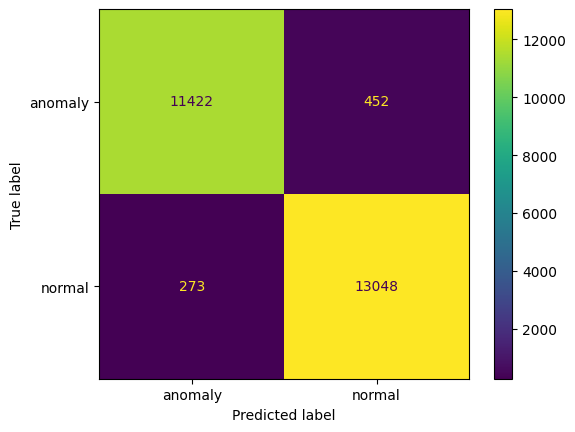

In [31]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_val_prep, y_val, values_format='3g')

## 2. Métricas derivadas de la matriz de confusión

### Precisión

In [32]:
from sklearn.metrics import precision_score
print('Precisión: ', precision_score(y_val, y_pred, pos_label='anomaly'))

Precisión:  0.9766566908935442


### Recall
Nos da una intución sobre el número de falsos negativos

In [33]:
from sklearn.metrics import recall_score

print('recall: ', recall_score(y_val, y_pred, pos_label='anomaly'))

recall:  0.9619336365167593


### F1 Score
Nos da una medida del rendimiento de predicción de nuestro algoritmo en base a la precisión y el recall

In [35]:
from sklearn.metrics import f1_score

print('F1 score', f1_score(y_val, y_pred, pos_label='anomaly'))

F1 score 0.9692392549535407


## 3. Curvas ROC y PR

### Curva ROC

c:\Users\luigi\.conda\envs\machine_learning\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


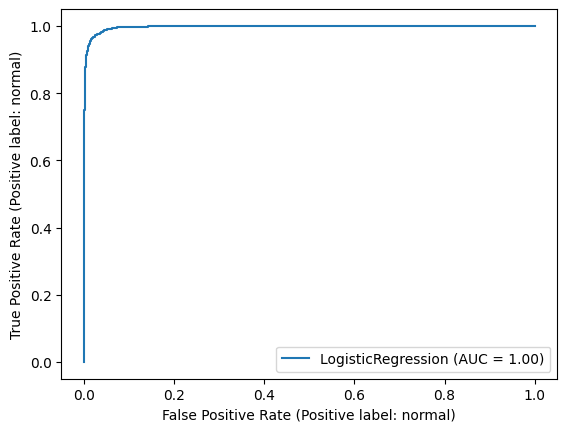

In [36]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(clf, X_val_prep, y_val)

### Curva PR

c:\Users\luigi\.conda\envs\machine_learning\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


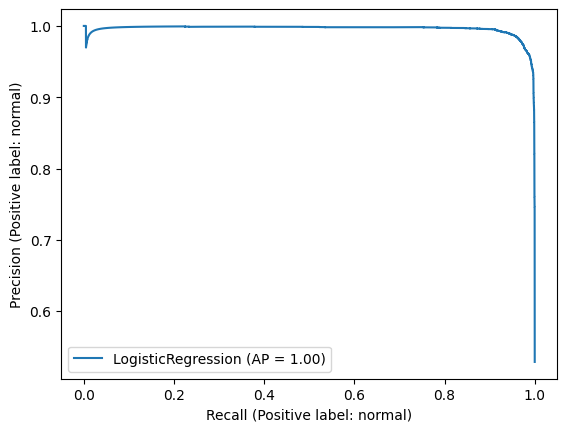

In [37]:
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(clf, X_val_prep, y_val)

## 4. Evaluación del modelo con el conjunto de datos de pruebas

In [42]:
# transformamos el subconjunto de datos de pruebas
X_test_prep = data_preparer.transform(X_test)

In [43]:
y_pred = clf.predict(X_test_prep)

c:\Users\luigi\.conda\envs\machine_learning\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


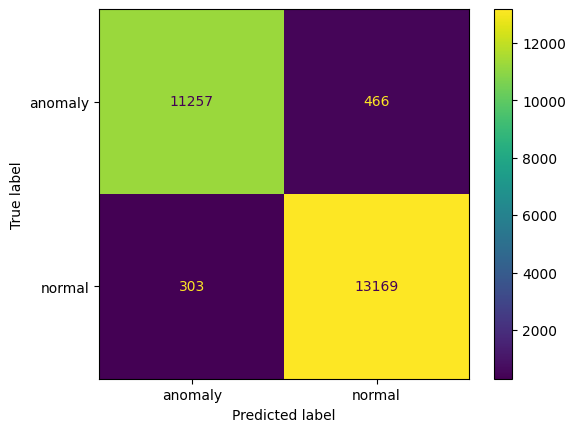

In [44]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_test_prep, y_test, values_format='3g')

In [45]:
print('F1 score:', f1_score(y_test, y_pred, pos_label='anomaly'))

F1 score: 0.9669716101876906
